## Reference
1) Approach: https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699  
2) Implicit Rating Normalization: https://www.cs.purdue.edu/homes/lsi/sigir04-cf-norm.pdf  
3) Adding dense layers: https://nipunbatra.github.io/blog/2017/recommend-keras.html  


In [67]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Input, Embedding, Dot, GRU, LSTM, Dense, Flatten, Concatenate, Dropout 

In [2]:
# Read all the files

data_folder = "input_data/"
proc_data_folder = "processed_data/"


aisles = pd.read_csv(os.path.join(data_folder, "aisles.csv"))
departments = pd.read_csv(os.path.join(data_folder, "departments.csv"))
products = pd.read_csv(os.path.join(data_folder, "products.csv"))


# Sample from the big files for now
order_prod_prior = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"))
order_prod_train = pd.read_csv(os.path.join(data_folder, "order_products__train.csv"))
orders = pd.read_csv(os.path.join(data_folder, "orders.csv"))


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
# Sample n users' orders,

random.seed(2018)

samples = 2000
all_user_ids = set(orders["user_id"].unique())
sampled_user_ids = sorted(random.sample(all_user_ids,samples))

order_samp = orders[orders["user_id"].isin(sampled_user_ids)]

[295, 461, 660, 791, 1026, 1318, 1362, 1404, 1568, 1574, 1699, 1839, 2020, 2179, 2206, 2985, 3061, 3214, 3283, 3322]


In [18]:
# Add products in these orders
data_samp = (order_samp.merge(order_prod_prior, on="order_id")
             .append(order_samp.merge(order_prod_train, on="order_id")))

# Add aisle and department ids 
data_samp = data_samp.merge(products, on="product_id", how="inner")

# Fill missing data
data_samp["days_since_prior_order"] = data_samp["days_since_prior_order"].fillna(0) 

In [23]:
# Fill missing data
data_samp["days_since_prior_order"] = data_samp["days_since_prior_order"].fillna(0) 

data_samp.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,3214808,295,prior,1,4,12,0.0,46802,1,0,Pineapple Chunks,116,1
1,1558179,295,prior,2,4,16,7.0,46802,9,1,Pineapple Chunks,116,1
2,2108239,295,prior,23,1,14,7.0,46802,15,1,Pineapple Chunks,116,1
3,3240249,791,prior,12,3,13,1.0,46802,3,0,Pineapple Chunks,116,1
4,1308488,3534,prior,14,5,10,30.0,46802,11,0,Pineapple Chunks,116,1


In [25]:
print(train_subset.shape, target_subset.shape)

(330271, 13) (13699, 13)


In [149]:
# Generate vocabulary for all available levels of each categorical feature
# Provide new monotonically increasing indices for each starting at 0

user_vocab = sorted(data_samp.user_id.unique())
user_vocab_size = len(user_vocab)
user_id_idx = dict(zip(user_vocab,range(user_vocab_size)))
data_samp["new_user_id"] = data_samp["user_id"].apply(lambda x: user_id_idx[x])


product_vocab = sorted(data_samp.product_id.unique())
product_vocab_size = len(product_vocab)
prod_id_idx = dict(zip(product_vocab,range(product_vocab_size)))
data_samp["new_product_id"] = data_samp["product_id"].apply(lambda x: prod_id_idx[x])


aisle_vocab = data_samp.aisle_id.unique()
aisle_vocab_size = len(aisle_vocab)
aisle_id_idx = dict(zip(aisle_vocab,range(aisle_vocab_size)))
data_samp["new_aisle_id"] = data_samp["aisle_id"].apply(lambda x: aisle_id_idx[x])

dept_vocab = data_samp.department_id.unique()
dept_vocab_size = len(dept_vocab)
dept_id_idx = dict(zip(dept_vocab,range(dept_vocab_size)))
data_samp["new_department_id"] = data_samp["department_id"].apply(lambda x: dept_id_idx[x])

In [150]:
print("Unique users: {}, products: {}, aisles: {}, departments: {}"
      .format(user_vocab_size, product_vocab_size,aisle_vocab_size,dept_vocab_size))

Unique users: 2000, products: 21510, aisles: 134, departments: 21


### Split into train and test

In [151]:
train_subset = data_samp[data_samp["eval_set"]=="prior"]
target_subset = data_samp[data_samp["eval_set"]=="train"]

In [465]:
# First, build a new index of users and products corresponding to the sample
# user_ids = [item for item in enumerate(user_product_freq.user_id.unique())] 
# new_user_ids = pd.DataFrame({"new_user_id":[i[0] for i in user_ids],
#              "user_id":[i[1] for i in user_ids]})

# product_ids = [item for item in enumerate(user_product_freq.product_id.unique())] 
# new_product_ids = pd.DataFrame({"new_product_id":[i[0] for i in product_ids],
#              "product_id":[i[1] for i in product_ids]})

# new_user_ids.describe()
# new_product_ids.describe()

### Build model

We build a neural network 1 with the following inputs:  
1) 3 categorical features are projected to embedding layers  
2) Integer features are consumed as is  
3) Information on the order_id is not used  

In [152]:
cat_columns = ["user_id","product_id","aisle_id","department_id"]
num_columns = ["order_number", "order_dow","order_hour_of_day","days_since_prior_order","add_to_cart_order"]

In [153]:
train_subset.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'new_product_id', 'new_aisle_id', 'new_department_id',
       'new_user_id'],
      dtype='object')

In [230]:
latent_dim_user = 10
latent_dim_product = 30
latent_dim_aisle = 10
latent_dim_dept = 10


user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(user_vocab_size, latent_dim_user, name="User-Embedding")(user_input)  
user_vec = Flatten(name="Flatten-Users")(user_embedding) # make a vector for the concat

prod_input = Input(shape=[1], name="Product-Input")
prod_embedding = Embedding(product_vocab_size, latent_dim_product, name="Product-Embedding")(prod_input)  
prod_vec = Flatten(name="Flatten-Products")(prod_embedding) # make a vector for the concat

aisle_input = Input(shape=[1], name="Aisle-Input")
aisle_embedding = Embedding(aisle_vocab_size, latent_dim_aisle, name="Aisle-Embedding")(aisle_input)
aisle_vec = Flatten(name="Flatten-Aisles")(aisle_embedding) # make a vector for the concat

dept_input = Input(shape=[1], name="Dept-Input")
dept_embedding = Embedding(aisle_vocab_size, latent_dim_aisle, name="Dept-Embedding")(dept_input)
dept_vec = Flatten(name="Flatten-Depts")(dept_embedding) # make a vector for the concat

num_input = Input(shape=[5], name="Numeric-Input")

concat = Concatenate()([user_vec, prod_vec, aisle_vec, dept_vec, num_input])

dense_1 = Dense(20,name='FullyConnected-1',activation='relu')(concat)
dropout_1 = Dropout(0.5,name='Dropout-1')(dense_1)

dense_2 = Dense(20,name='FullyConnected-2',activation='relu')(dropout_1)
dropout_2 = Dropout(0.5,name='Dropout-2')(dense_2)

output = Dense(1,name='FullyConnected-Output', activation='sigmoid')(dropout_2)

model = Model([user_input, prod_input, aisle_input, dept_input, num_input], output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [231]:
# del model

In [232]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
Product-Input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
Aisle-Input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
Dept-Input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embed

In [234]:
history = model.fit([train_subset.new_user_id, train_subset.new_product_id, 
                     train_subset.new_aisle_id, train_subset.new_department_id,
                    train_subset[num_columns]], 
                    train_subset.reordered,
                    validation_split = 0.1,
                    epochs=5, verbose=1)
model.save('classification_model.h5')

Train on 297243 samples, validate on 33028 samples
Epoch 1/5
297243/297243 [==============================] - 66s 222us/step - loss: 0.5542 - acc: 0.7211 - val_loss: 0.5695 - val_acc: 0.6841
Epoch 2/5
297243/297243 [==============================] - 67s 226us/step - loss: 0.5253 - acc: 0.7392 - val_loss: 0.5576 - val_acc: 0.6992
Epoch 3/5
297243/297243 [==============================] - 68s 228us/step - loss: 0.5171 - acc: 0.7457 - val_loss: 0.5543 - val_acc: 0.7074
Epoch 4/5
297243/297243 [==============================] - 67s 224us/step - loss: 0.5140 - acc: 0.7491 - val_loss: 0.5566 - val_acc: 0.6994
Epoch 5/5
297243/297243 [==============================] - 67s 224us/step - loss: 0.5119 - acc: 0.7524 - val_loss: 0.5570 - val_acc: 0.7064


Text(0,0.5,'Train Error')

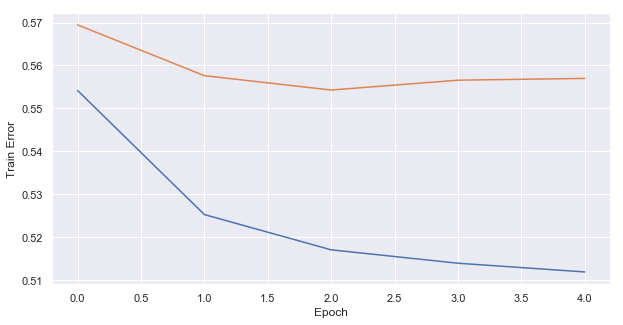

In [235]:
pd.Series(history.history['loss']).plot()
pd.Series(history.history['val_loss']).plot()
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In seems that the model starts to overfit already in the first training epochs

In [236]:
# Extract embeddings for users
user_em = model.get_layer('User-Embedding')
user_em_weights = user_em.get_weights()[0]

# Extract embeddings for products
prod_em = model.get_layer('Product-Embedding')
prod_em_weights = prod_em.get_weights()[0]

# Extract embeddings for aisles
aisle_em = model.get_layer('Aisle-Embedding')
aisle_em_weights = aisle_em.get_weights()[0]

# Extract embeddings for departments
dept_em = model.get_layer('Dept-Embedding')
dept_em_weights = dept_em.get_weights()[0]

Each product id has received *n* coordinates in the product embedding space (correspondent to latent_dim parameter)  
Each department has received *m* coordinates in the user embedding space

In [237]:
print(user_em_weights.shape, prod_em_weights.shape, aisle_em_weights.shape, dept_em_weights.shape)

(2000, 10) (21510, 30) (134, 10) (134, 10)


Is there any structure in this space - are the products somehow separated from each other?

Text(0.5,1,'PCA: Department Embeddings')

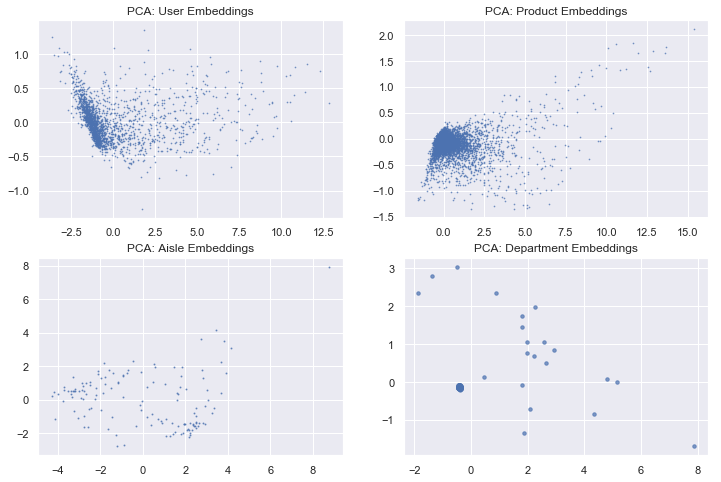

In [238]:
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

user_pca_result = pca.fit_transform(user_em_weights)
prod_pca_result = pca.fit_transform(prod_em_weights)
aisle_pca_result = pca.fit_transform(aisle_em_weights)
dept_pca_result = pca.fit_transform(dept_em_weights)

# prepare image and figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize = (12,8))

ax1.scatter(x=user_pca_result[:,0], y=user_pca_result[:,1],alpha=0.7,s=0.5)
ax1.set_title("PCA: User Embeddings")
ax2.scatter(x=prod_pca_result[:,0], y=prod_pca_result[:,1],alpha=0.7,s=0.5)
ax2.set_title("PCA: Product Embeddings")
ax3.scatter(x=aisle_pca_result[:,0], y=aisle_pca_result[:,1],alpha=0.7,s=1)
ax3.set_title("PCA: Aisle Embeddings")
ax4.scatter(x=dept_pca_result[:,0], y=dept_pca_result[:,1],alpha=0.7,s=12)
ax4.set_title("PCA: Department Embeddings")



There is a clear structure that separates products, and it is more complex than 2 dimensions

For users, it also looks like both dimensions show distances between departments that are sufficient to identify clusters

### Evaluate the model


In [239]:
predictions = model.predict([target_subset.new_user_id,target_subset.new_product_id, 
                             target_subset.new_aisle_id, target_subset.new_department_id,
                             target_subset[num_columns]])

In [240]:
out = target_subset
out["pred_prob"] = predictions

thresh = 0.5

out.loc[out["pred_prob"]>thresh,"pred_label"] = 1
out.loc[out["pred_prob"]<=thresh,"pred_label"] = 0
out.head(10)

/Users/dima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dima/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,new_product_id,new_aisle_id,new_department_id,new_user_id,pred_prob,pred_label
292,405264,295,train,24,2,14,8.0,46802,7,1,Pineapple Chunks,116,1,20240,0,0,0,0.863465,1.0
293,359518,2206,train,10,1,16,30.0,46802,11,0,Pineapple Chunks,116,1,20240,0,0,14,0.678292,1.0
294,310611,4330,train,6,0,19,30.0,46802,25,0,Pineapple Chunks,116,1,20240,0,0,32,0.353765,0.0
295,1416669,6814,train,10,4,16,9.0,46802,18,0,Pineapple Chunks,116,1,20240,0,0,53,0.399230,0.0
296,2874152,20903,train,18,1,16,29.0,46802,15,1,Pineapple Chunks,116,1,20240,0,0,198,0.734045,1.0
297,1122119,43551,train,22,4,10,8.0,46802,6,0,Pineapple Chunks,116,1,20240,0,0,416,0.788370,1.0
298,2948038,45047,train,4,5,16,30.0,46802,1,0,Pineapple Chunks,116,1,20240,0,0,431,0.721400,1.0
299,1316906,47961,train,18,6,13,24.0,46802,5,1,Pineapple Chunks,116,1,20240,0,0,456,0.806429,1.0
300,1890512,58538,train,26,5,12,30.0,46802,1,1,Pineapple Chunks,116,1,20240,0,0,563,0.849185,1.0
301,3287626,101790,train,13,0,14,4.0,46802,5,0,Pineapple Chunks,116,1,20240,0,0,975,0.566841,1.0


count    13699.000000
mean         0.622112
std          0.194936
min          0.001159
25%          0.498832
50%          0.599884
75%          0.763895
max          0.999864
Name: pred_prob, dtype: float64

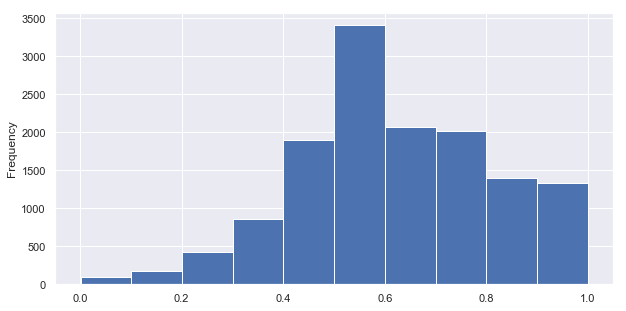

In [241]:
out.pred_prob.plot.hist()
out.pred_prob.describe()

In [242]:
y_test = out["reordered"]
predictions = out["pred_label"]

acc_baseline = y_test.reset_index().groupby("reordered").count()
acc_baseline["class_share"] = acc_baseline["index"]/ acc_baseline["index"].sum()
acc_baseline["class_share"].max()

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("vs. baseline {:.2%}".format(acc_baseline["class_share"].max().astype("float")))

Accuracy: 68.76%
vs. baseline 61.18%


In [243]:
%run plot_confusion_matrix.py

Normalized confusion matrix


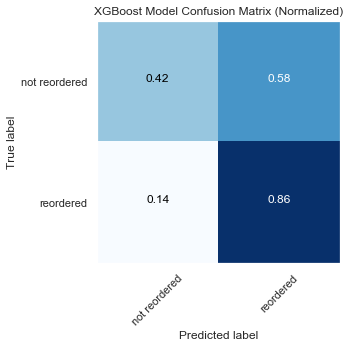

In [244]:
class_names = ["not reordered", "reordered"]
cnf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(False)
fig = plot_confusion_matrix(cnf_matrix, classes=class_names,
                            normalize=True,
                            title='XGBoost Model Confusion Matrix (Normalized)')
# fig.rcParams['figure.figsize'] = [5, 5]

In [245]:
f1_score(y_true=y_test, y_pred=predictions)

0.7702136798024267

## Model description

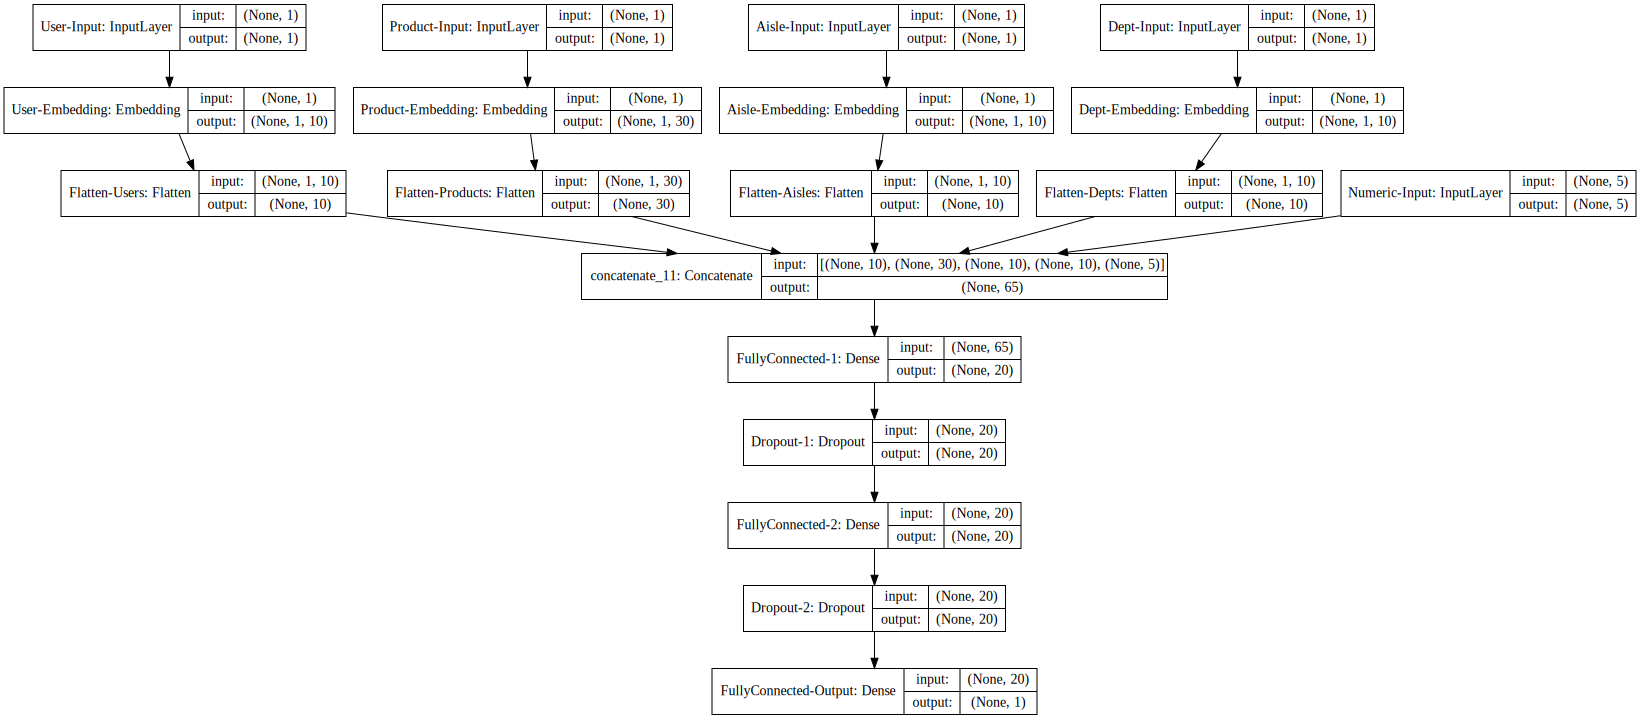

In [246]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))